# Investigative Report of ANES Voter 

## By Theodore Fong

This report will answer 5 questions of my personal interest in voting trends of the 2018 ANES report:
1. Do US voters have more respect for the police or for journalists?
2. Are Republican voters older or younger than Democratic voters?
3. Do a majority of independent voters believe that the federal investigations of Russian election interference are baseless?
4. Was anger or fear more effective at driving increases in voter turnout from 2016 to 2018?
5. Select a fifth question that you believe is important for understanding the behavior of voters


### The Data

The American National Election Studies (ANES) conducts surveys of voters in the United States.  While its flagship survey occurs every four years at the time of each presidential election, ANES also conducts pilot studies midway between these elections.  This report will examine the data from the 2018 ANES Pilot Study.

For reference to the intricacies in the design of this study, refer to the [ANES User's Guide and Codebook](https://electionstudies.org/wp-content/uploads/2019/02/anes_pilot_2018_userguidecodebook.pdf).

#### Disclaimer
An important disclaimer is that the ANES Pilot Study does not represent a random sample of the U.S. population.  Participants are taken from the YouGov panel, which is an online system in which users earn rewards for completing questionnaires.  This feature limits the extent to which results generalize to the U.S. population. To account for differences between the YouGov panel and the U.S. Population, ANES assigns a survey weight to each observation.  This weight estimates the degree to which a citizen with certain observed characteristics is over- or under-represented in the sample. 

The following is an example of a question asked on the ANES survey:

> How difficult was it for you to vote in this last election?

The variable `votehard` records answers to this question, with the following encoding:

- -1 inapplicable, legitimate skip
- 1 Not difficult at all
- 2 A little difficult
- 3 Moderately difficult
- 4 Very difficult
- 5 Extremely difficult


To see the precise form of each question, take a look at the [Questionnaire Specifications](https://electionstudies.org/wp-content/uploads/2018/12/anes_pilot_2018_questionnaire.pdf).

In [5]:
A = read.csv("anes_pilot_2018.csv")

## Q1: Do US voters have more respect for the police or for journalists?

The initial intuition for this question is that we need to find two variables: one measuring individuals' feelings towards police and the other measuring their feelings towards journalist. If we have these data points for each individual, we should be able to run a two-tailed paired t-test (or Wilcox-Rank-Sign test if the variables are ordinal or come from a Likert scale) with a null hypothesis that the mean difference between the two variables is equal to 0. 

The dataset gives us the variables 'ftpolice' and 'ftjournal', which were the answers to "How would you rate the police/journalists?" From the survey's user guide, we note that both questions were to be answered on a scale of 0-100 using a temperature "widget." Although this variable is not exactly continuous, we assume it is cardinal as the difference between values is consistent and meaningful. 

We can operationalize these variable to answer our question by assuming a higher score on the scale is correlated with a higher respect level for the identified group. For example, if a respondent gives a score of 75 for police and a score of 25 for journalists, this would indicate the respondent has more respect for police than journalists.

## EDA
The survey records negative values as responses for individuals who did not answer each question. We need to check for any non-responses in our data.

In [2]:
summary(A$ftjournal >-1)

   Mode   FALSE    TRUE 
logical       2    2498 

In [3]:
summary(A$ftpolice >-1)

   Mode    TRUE 
logical    2500 

These quick summaries reveal several key pieces of information. First, we have data from 2,500 individuals--a rather large sample size. Second, two of these individuals provided no response to the question about journalists. We should omit these values from consideration, as "non-response" does not necessarily shift the mean in the negative direction (indicated less respect). Additionally, since we are considering a paired t-test, it would make sense to remove the scores these same individuals provided for police officers. Thus, the two individuals who failed to answer the journalist question are removed from our analysis.  

We now rename our variables after filtering out the necessary responses.

In [4]:
journal <- A[A$ftjournal > -1, 'ftjournal']
police <- A[A$ftjournal > -1, 'ftpolice']

We are interested in the distribution of the paired differences between the variables, so we look at the histogram below, revealing the distribution of the difference between ratings for police and ratings for journalists.

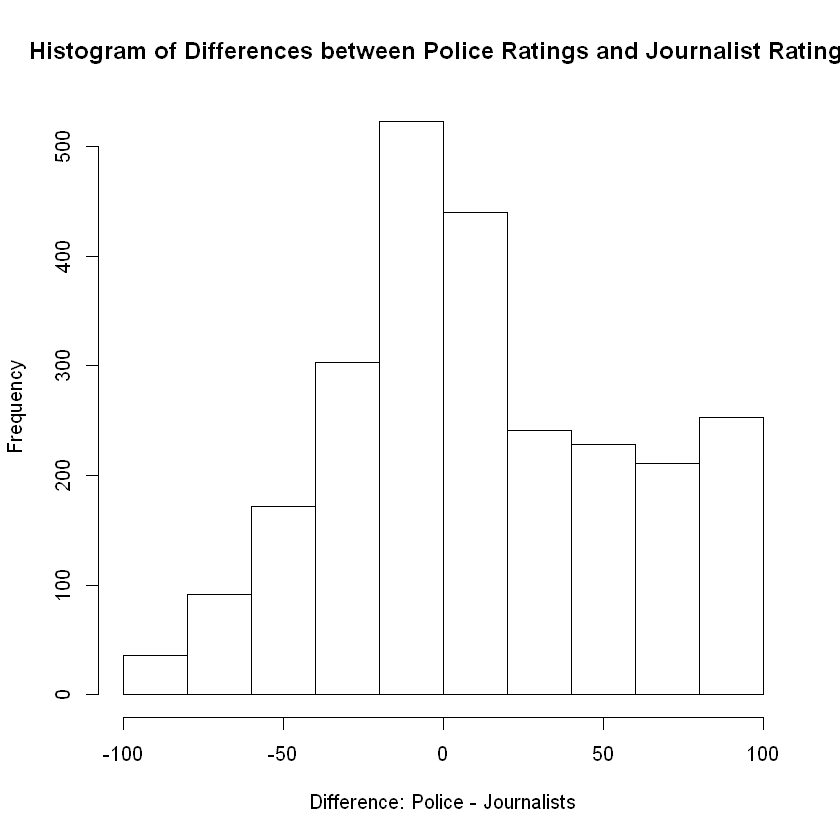

In [23]:
hist(police-journal, 
     main= "Histogram of Differences between Police Ratings and Journalist Ratings", 
     xlab = "Difference: Police - Journalists")


The histogram reveals the difference in scores given to police and journalists is approximately normal- an important assumption we need to satisfy in order to run certain hypothesis tests.


After our EDA and sanity checks above, we decide to follow through with our initial to run a paired t-test.

We note the key assumptions for this test are met:

- There are two variables we wish to compare for the same group of individuals- the variables are not independent and must be paired.
- We have a large sample, and the distribution (of the paired difference) is approximately normal.
- We have a test statistic that can compare the mean paired difference against a null hypothesis that the difference is zero. The alternative hypothesis is that there is a non-zero difference. Because we have no reason to believe the difference would be positive or negative, we opt for a two-tailed test.

We run the test at a significance level of 0.05.  

## T-Test

In [6]:
t.test(police, journal, paired=T)


	Paired t-test

data:  police and journal
t = 13.711, df = 2497, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 10.58776 14.12160
sample estimates:
mean of the differences 
               12.35468 


With a p-value p > 0.05, we have a statistically significant result, and reject the null hypothesis that the true difference between the means is equal to 0. We have found support for our alternative hypothesis that the true mean does not equal zero. 

As seen from the test output, the mean of the differences from our sample was 12.35, and our 95% confidence interval ranges from 10.59 to 14.12. 0 is not contained in this confidence interval (again, a reason to reject our $H_0$). 

We next should consider the practical significance of our result. To do this, we write a function for cohen's d, a common effect size standard.

In [7]:
cohens_d <- function(x, y) {
    lx <- length(x)- 1
    ly <- length(y)- 1
    md  <- abs(mean(x) - mean(y))        ## mean difference (numerator)
    csd <- lx * var(x) + ly * var(y)
    csd <- csd/(lx + ly)
    csd <- sqrt(csd)                     ## common sd computation

    cd  <- md/csd                        ## cohen's d
    return(cd)
}

We now compute Cohen's d for the test we ran.

In [8]:
cohens_d(police, journal)

[1] 0.4021677

With d between 0.2 and 0.5, the effect size here is between "small" and "medium." Thus, we can understand that there is some moderate practical significance in the difference in levels of respect individuals have for police officers and journalists.

## Q2: Are Republican voters older or younger than Democratic voters?

Intuition suggests we will need to divide our population into two groups- Republican voters and Democratic voters.
From there, we would look to find the average age of individuals within each group, and compare the means using a two-tailed t-test for independent samples (with a null hypothesis that there is no difference between the mean ages of the two groups).

While the survey does not explicitly as for each respondent's party affiliation, it does ask the following question:
"Generally speaking, do you usually think of yourself as a Democrat, a Republican, an independent, or what?" The survey introduced a randomization variable for this question, presenting the Democratic and Republican party names in different orders in different cases. We need to examine the results of both of these--pid1d and pid1r.

An individual who answered the pid1d version of the question will have automatically scored a -1 for the pid1d version (and vice versa). As such, we will filter each variable and pull out only those individuals who answered either Democrat (indicated by a response of 1) or Republican(indicated by a response of 2) on whichever version of the question they received.

Unfortunately, "Age" is not a variable that can be found in the data. However, the variable "birthyr" records the year of birth of each of the survey's respondents, which is just as good. We should be able to extract the birthyears from each individual to use in our analysis (with the idea that earlier or "smaller" birthyears indicate greater age.


## EDA

We first look to filter the data and pull out only the variables we need (party affiliation as indicated by the pid1d and pid1r variables, and birthyr)

In [9]:
q2vars <- names(A) %in% c('pid1d', 'pid1r', 'birthyr')
q2data <- A[q2vars]

dems <- subset(q2data, pid1d == 1 | pid1r == 1, select=c(birthyr))
repubs <- subset(q2data, pid1d == 2 | pid1r == 2, select=c(birthyr))

We then look at sample sizes we have for each group:

In [10]:
length(dems$birthyr)
length(repubs$birthyr)

[1] 857

[1] 609

We can consider both these samples sufficiently large. We next aim to analyze the shape of the distribution of each group with histograms.

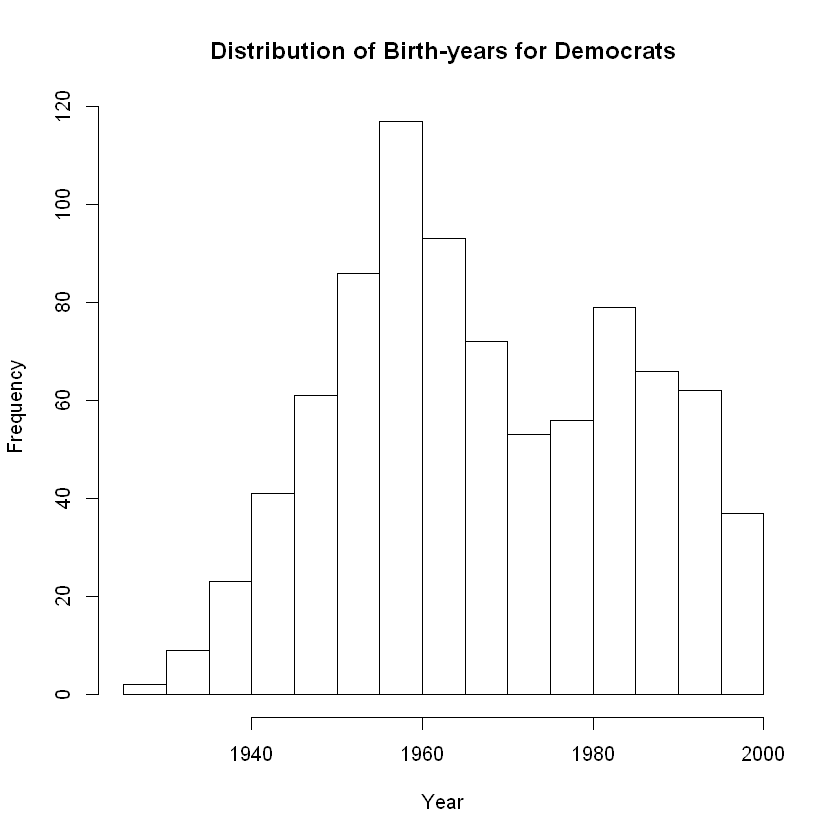

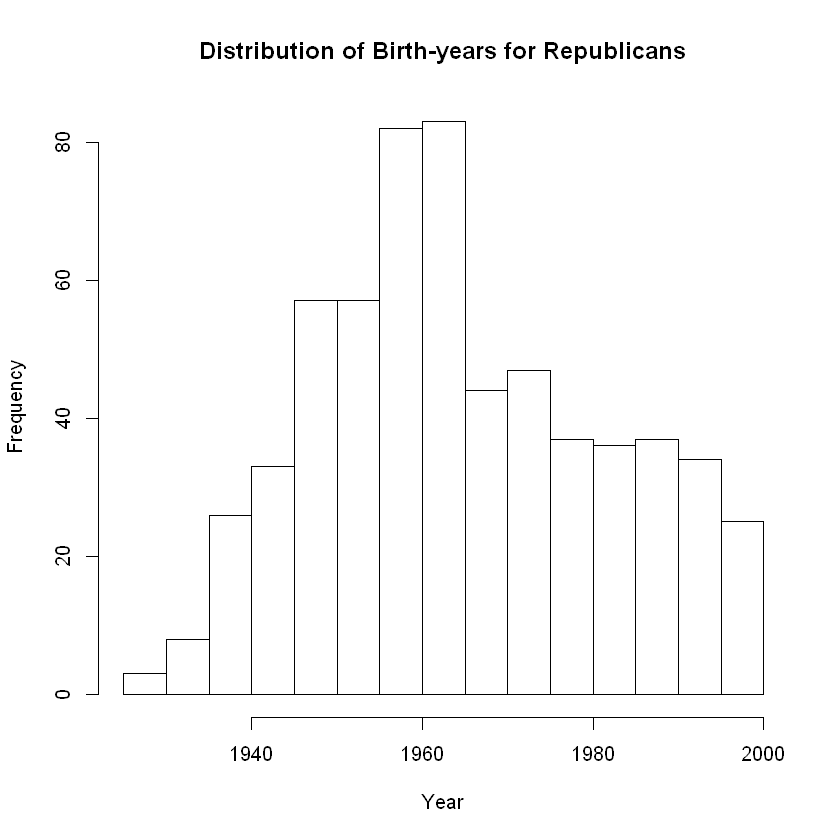

In [11]:
hist(dems$birthyr, main = "Distribution of Birth-years for Democrats", xlab = "Year")
hist(repubs$birthyr, main = "Distribution of Birth-years for Republicans", xlab = "Year")

We note the shape of both distributions are approximately normal, which will help us in our determination of which hypothesis test to run.


An appropriate hypothesis test here is a two-sided independent samples t-test. We assume the two groups are independent of one another as there is no natural pairing between the two. The variable of interest (birthyear) is cardinal, and the distribution of both groups is approximately normal. 

We run this two-sided test with the null hypothesis there is no difference between the mean birthyears of the two groups (with the alternative hypothesis that the mean difference is not equal to 0). We run the test at the 0.05 significance level.

## T-Test

In [12]:
t.test(dems, repubs)


	Welch Two Sample t-test

data:  dems and repubs
t = 2.939, df = 1309.7, p-value = 0.00335
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.8718651 4.3723921
sample estimates:
mean of x mean of y 
 1967.767  1965.144 


We discover a p-value p < 0.05, a statistically significant result at the 0.05 level. We thus reject our null hypothesis (that the difference in means is equal to zero) having found support for our alternate hypothesis (that the mean difference is not equal to zero). The mean difference of our sample was greater than two, and we also notice that zero does not fall within our 95% confidence interval. 

We do question whether or not this data is practically significant. That the mean age of Republicans is greater than the mean age of Democrats (a difference in a couple years) may not be that big of a deal, especially when the average age of both groups represents individuals in their early fifties at the time of the survey.

We can calculate Cohen's d to measure the effect size of our result.

In [13]:
cohens_d(dems$birthyr, repubs$birthyr)

[1] 0.155755

With a value for d less than 0.2, we say the effect size here is small. Our initial test may suggest that Republicans are older than Democrats at a statistically significant level (and indeed, we could rerun the test as a one-sided test with *t.test(dems, repubs, alternative = 'greater')*, this would not be good statistical practice, as we would be changing from a two-sided test to a one-sided test when we notice something after the fact), yet we probably do not care enough about how different the ages actually are. The significant result is likely a consequence of the large sample sizes of the two groups.  

## Q3: Do a majority of independent voters believe that the federal investigations of Russian election interference are baseless?

To answer this question we will need to find a subset of the data including only those voters who identify as independents. Like before, we will need to use the pid1d and pid1r variables to find this. We will then try to find variables that represent these individual's sentiments regarding the investigations. We note there may be difficulty interpreting the idea of "baseless." Variables of interest most likely arise from a question and a response using a type of Likert scale with terms like "agree"/"disagree" or "approve"/"disapprove." Our initial belief is that we should be able to run a one-tailed hypothesis test (likely a non-parametric one if the variable is ordinal) with a null hypothesis that independent voters' feelings regarding the federal investigations are neutral, and an alternative hypothesis that such feelings are negative (or baseless).

## EDA
We begin by getting the appropriate subset of independent voters, and pull out three variables that could be of interest: russia16 (a response to the question, "Do you think the Russian government probably interfered in the 2016 presidential election to try to help Donald Trump win, or do you think this probably did not happen?"), muellerinv (a response to the question, "Do you approve, disapprove, or neither approve nor disapprove of Robert Mueller’s investigation of Russian interference in the 2016 election?"), and coord16 (a response to the question, "Do you think Donald Trump’s 2016 campaign probably coordinated with the Russians, or do you think his campaign probably did not do this?").

In [14]:
q3vars <- names(A) %in% c('pid1d', 'pid1r', 'muellerinv', 'russia16', 'coord16')
q3data <- A[q3vars]

ind <- subset(q3data, pid1d == 3 | pid1r == 3, select=c(muellerinv, russia16, coord16))

We have reason to believe these variables may not be independent from one another-- an independent who does not think the Russian government interfered in the election probably disapproves of the Mueller investigation and does not think the Trump campaign coordinated with the Russians. 

We run a chi-squared test for independence on each pair of these variables.

In [15]:
chisq.test(ind$muellerinv, ind$russia16)
chisq.test(ind$muellerinv, ind$coord16)
chisq.test(ind$russia16, ind$coord16)


	Pearson's Chi-squared test

data:  ind$muellerinv and ind$russia16
X-squared = 382.04, df = 6, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  ind$muellerinv and ind$coord16
X-squared = 423.2, df = 6, p-value < 2.2e-16



	Pearson's Chi-squared test with Yates' continuity correction

data:  ind$russia16 and ind$coord16
X-squared = 500.06, df = 1, p-value < 2.2e-16


In each case, we get significantly low p-values, suggesting the variables are not independent of one another, as our intuition suggested. As such, we narrow our analysis to one variable (muellerinv), which seems most appropriate to answer our research question. 

We quickly check the size and distribution of our sample:

[1] 767

[1] 767

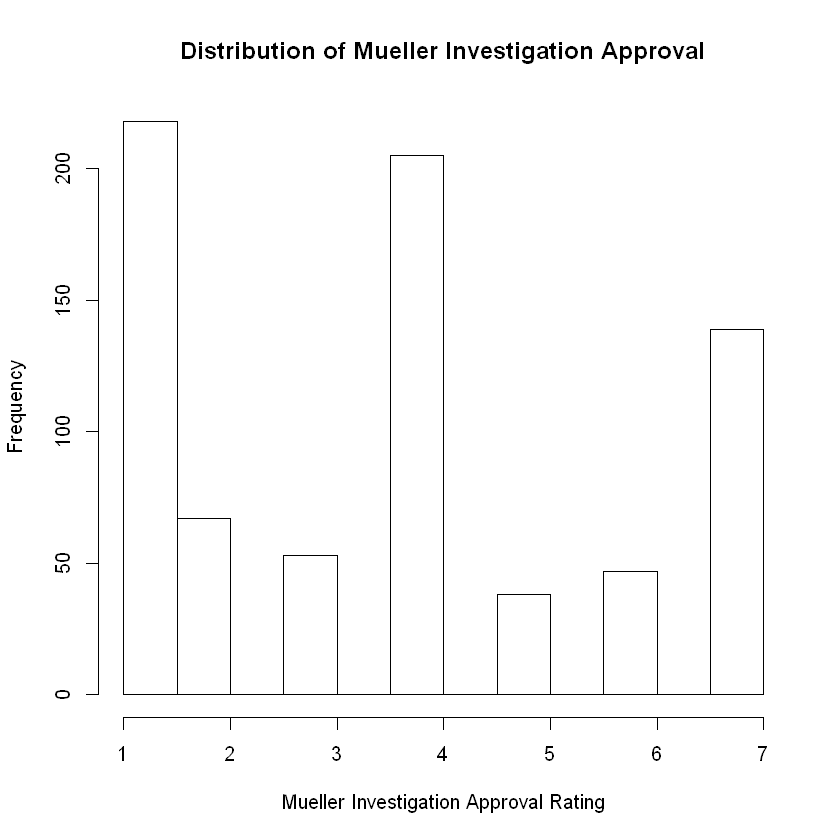

In [22]:
length(ind$muellerinv)
length(ind$muellerinv >-1)
hist(ind$muellerinv, main = "Distribution of Mueller Investigation Approval", 
     xlab = "Mueller Investigation Approval Rating")

We have a sample of 767 responses (with no non-responses to remove), and an interesting distribution shape. The unusual shape can be somewhat explained by the fact that the muellerinv variable is ordinal, arising from a Likert scale. This will be an important factor in deciding on an appropriate hypothesis test.

We opt here for a a Wilcox-Rank-Sum test. This choice was aided by the fact that our variable of interest (muellerinv) comes from a Likert scale (and thus is ordinal), and the fact that non-parametric tests are distribution free, recalling the odd nature of our distribution.
As suggested by the research question, our test will be one-tailed, with the null hypothesis that independents' feelings on average are "neutral," represented by a score of 4 in the data, and the alternative hypothesis that these feelings are negative (ie. independents, on average, disapprove of the investigations). 

## T-Test
Explain (1) the statistical significance of your result, and (2) the practical significance of your result.  Make sure you relate your findings to the original research question.

In [17]:
wilcox.test(ind$muellerinv, alternative="greater", mu=4, conf.int=T)


	Wilcoxon signed rank test with continuity correction

data:  ind$muellerinv
V = 62104, p-value = 1
alternative hypothesis: true location is greater than 4
95 percent confidence interval:
 3.500018      Inf
sample estimates:
(pseudo)median 
      3.999955 


Our p-value is essentially 1, suggesting that we fail to reject the null hypothesis. Indeed, the 'pseudo-median' or center of the data is almost exactly 4, representing neutral feelings towards the investigations. We do not have any evidence to support the alternative hypothesis, that a majority of independent voters believe that the federal investigations of Russian election interference are "baseless."

## Q4: Was anger or fear more effective at driving increases in voter turnout from 2016 to 2018?

We are tasked with identifying causes of increases to voter turnout from 2016 to 2018.  Interpreting this challenge is a bit of a challenge.  It presumes that there was an increase in voter turnout from 2016 to 2018, according to public reporting 2018 had 49.3% voter turnout, and 2016 had 61.4% voter turnout.  This public reporting is supported through our exploratory data analysis of this survey.  It's true that election turnout in 2018 was significantly higher than election turnout in the previous midterms; but that doesn't help us address what was effective "at driving increases in voter turnout from 2016 to 2018".  The only reasonable way to approach this problem, given the question, is to look at those people who didn't turn out in 2016 and yet did turn out in 2018, and to assess whether fear or anger is the more salient motivator.

There are some challenges in operationalizing this data.  For instance, survey responses on voter turnout in both 2016 and 2018 can be answered by responding "Not Completely Sure".  A follow up question asks "Do you think you probably voted or probably did not vote?"  We've chosen to ignore respondents who aren't sure if they voted or not.  Even if a respondent suspects that they turned out to vote, we'd rather deal with a slightly reduced sample size, than to have to consider introducing that uncertainty.  

Another decision that we had to make was which variables to use as a representation for anger and fear.  There were three emotion batteries on the survey, one that captured the respondents feelings towards trump, one that captured feelings around immigration, and a global emotion battery.  Because it's hard to say that the decision to vote or not to vote was informed by Donald Trump solely or Immigration solely, we used the global emotion battery

## EDA

In [8]:

cat("People who definitely voted in 2016")
TurnoutSize16 <- subset(A, turnout16 == 1)
length(TurnoutSize16$weight)

cat("People who definitely voted in 2018")
TurnoutSize18 <- subset(A, turnout18 == 1)
length(TurnoutSize18$weight)

People who definitely voted in 2016

[1] 1841

People who definitely voted in 2018

[1] 968

The above data demonstrates that a tenet of the question might be wrong.  There doesn't actually appear to have been increases in voter turnout from 2016 to 2018, and it lends support to the approach of only focusing on those voters who didn't vote in 2016 and did in 2018.

It was now time to look at how survey responses for geangry and geafraid were distributed and whether there were any responses that needed to be removed

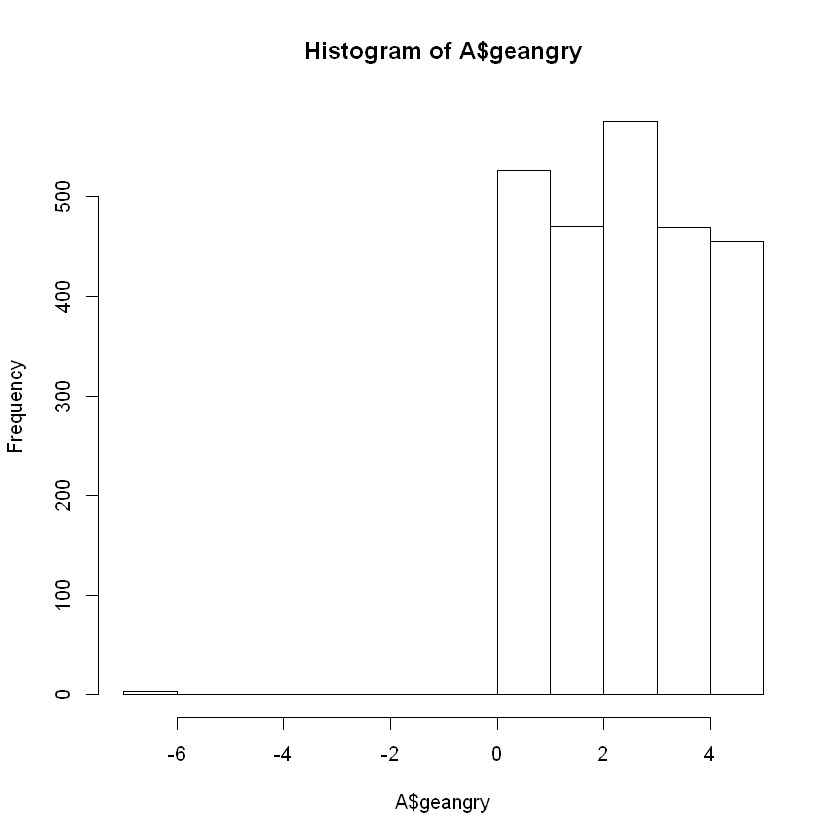

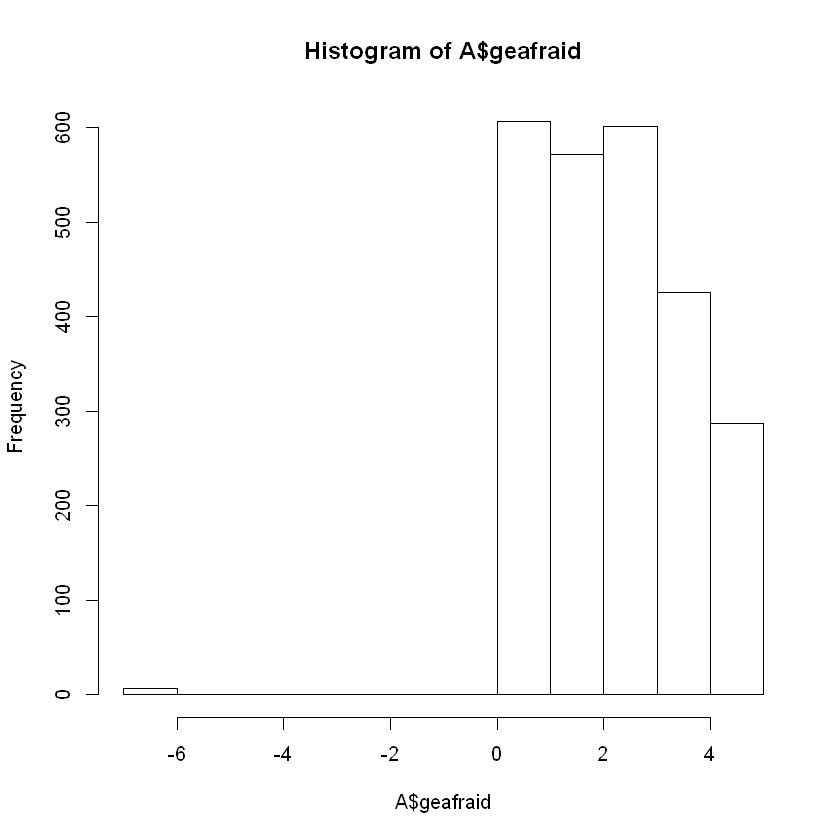

In [9]:
hist(A$geangry)
hist(A$geafraid)

Through this exploratory data analysis, we can see that anger is pretty close to being uniformly distributed throughout the responses while responses of "very" or "extremely" appear slightly less common for the emotion of fear.  We can also see that there are a few responses of -7.  From reading the user guide codebook we can see that this indicates a non response.  As a result, we should remove these respondents from the analysis

In [11]:
D <- subset(A, geafraid != -7 & A$turnout18 != 5 & A$turnout16 != 3)
D$TurnoutIncrease <- ifelse(D$turnout16 == 2 & (D$turnout18 == 1 | D$turnout18 == 2 | D$turnout18 == 3),1,0)

D$FearOrAnger[D$geangry > D$geafraid] <- 0
D$FearOrAnger[D$geangry == D$geafraid] <- 1
D$FearOrAnger[D$geafraid > D$geangry] <- 2
    
cat("Total Population Certain of how they voted")
length(D$weight)

E <- subset(D, TurnoutIncrease == 1)
F <- subset(D, TurnoutIncrease == 0)
cat("Total Population who didn't vote in 2016 and did in 2018")
length(E$weight)
AngryVoters <- subset(D, geangry > geafraid)
cat("Total Population of certain voters with more anger than fear")
length(AngryVoters$weight)
FearfulVoters <- subset(D, geangry < geafraid)
cat("Total Population of certain voters with more fear than anger")
length(FearfulVoters$weight)
AngryTurnout <- subset(AngryVoters, TurnoutIncrease == 1)
cat("Total Angry voters who didn't vote in 2016 and did in 2018")
length(AngryTurnout$weight)
FearfulTurnout <- subset(FearfulVoters, TurnoutIncrease == 1)
cat("Total Fearful voters who didn't vote in 2016 and did in 2018")
length(FearfulTurnout$weight)

cat("total sample observations with the same levels of fear and anger")
FearAndAnger <- subset(D, geangry == geafraid)
length(FearAndAnger$weight)

Count <- c(length(AngryVoters$weight), length(FearfulVoters$weight))
Success <- c(length(AngryTurnout$weight),length(FearfulTurnout$weight))


Total Population Certain of how they voted

[1] 2326

Total Population who didn't vote in 2016 and did in 2018

[1] 96

Total Population of certain voters with more anger than fear

[1] 811

Total Population of certain voters with more fear than anger

[1] 481

Total Angry voters who didn't vote in 2016 and did in 2018

[1] 24

Total Fearful voters who didn't vote in 2016 and did in 2018

[1] 25

total sample observations with the same levels of fear and anger

[1] 1034

To test whether fear or anger was more effective at driving increases in voter turnout from 2016 to 2018, we need to look at the test population and look for a difference between the geangry and geafraid variables within the group representing an increase in voter turnout.  To perform that test, we will need to use the Wilcoxon signed rank test.  This test is used rather than a t-test because we are dealing with ordinal data.  Our data meets all of the criterion for a Wilcoxon Sign-ranked test; the data are paired and come from the same population, the observations are independent, and they are measured on an ordinal scale.

We need to point out that if we run the test this way, we won't be able to say that any one person will be more motivated to turn out based on their respective fear or anger levels, we will only be able to say in aggregate whether fear or anger appears to be more strongly represented in the turnout increase population.  Through our exploratory analysis, we've already seen evidence that suggests that the general population is more angry than they are fearful.  But if more people are angry than are fearful, we could say that makes anger "more effective at driving increases in voter turnout from 2016 to 2018" even if an angry person is just as likely as a fearful person to be motivated to turn out.  Thus, the real test of what is effective at driving voter turnout is the relative proportions of anger and fear in the turnout group.

## T-Test

In [20]:
wilcox.test(E$geangry,E$geafraid, paired = TRUE)


Warning message in wilcox.test.default(E$geangry, E$geafraid, paired = TRUE):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(E$geangry, E$geafraid, paired = TRUE):
"cannot compute exact p-value with zeroes"


	Wilcoxon signed rank test with continuity correction

data:  E$geangry and E$geafraid
V = 599, p-value = 0.8917
alternative hypothesis: true location shift is not equal to 0


Because ties exist, we've run the test with a continuity correction and the result is essentially throwing these data points out.  This doesn't nullify the p-value, it just means that it is now an approximate P-value instead of an exact p-value.  Either way, with a P-value of .8917, we do not have sufficient evidence to reject the null and we can not conclude that either anger or fear is a more effective driver of voter turn out from 2016 to 2018. 

## Q5: Select a fifth question that you believe is important for understanding the behavior of voters

Question and relevance.
Our question is "Do people that intend to vote for President Trump in 2020, believe that Trump is handling the economy well?". One of the top reasons that people stated for voting for Trump in 2016 was that they believed he would improve the economy. Therefore, this is a significant question for the democratic party, because the U.S. economy is on a potential depression and has been bouncing up and down over the past three months. If Trump voters feel stronger than moderate approval for his handling of the economy but the economy continues to falter over the next year, then Trump voters dissappointed with economic performance may be a swing voter target for Democrats. 

Variables
We will examine the econpres through the vote20jb, and vote20ew variables. We'll filter the data set from vote20ew and vote20jb based on if they would vote for Trump or not and then examine the econpres variable. 

Plan
vote20jb and vote20ew are the two variables that best depict if someone intends to vote for Trump instead of another democratic nominee. As the two potential frontrunners of the democratic party, it also makes logical sense. econpres is the best variable to examine how much an individual approves of Trump's handling of the economy. econ12pres examines if an individual thought the economy would be better in 12 months, but doesn't quite capture if Trump was influencing the economy and since the survey was conducted in December 2018, would not represent the 2020 election which is what the question is investigating.

Reason
We chose this particular question because it addresses the idea that people vote for Trump because they care about economics, while demonstrating our understanding of hypothesis tests with a one sample t-test.

## EDA

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.476   2.000   5.000 

[1] 0.7960371

[1] 824

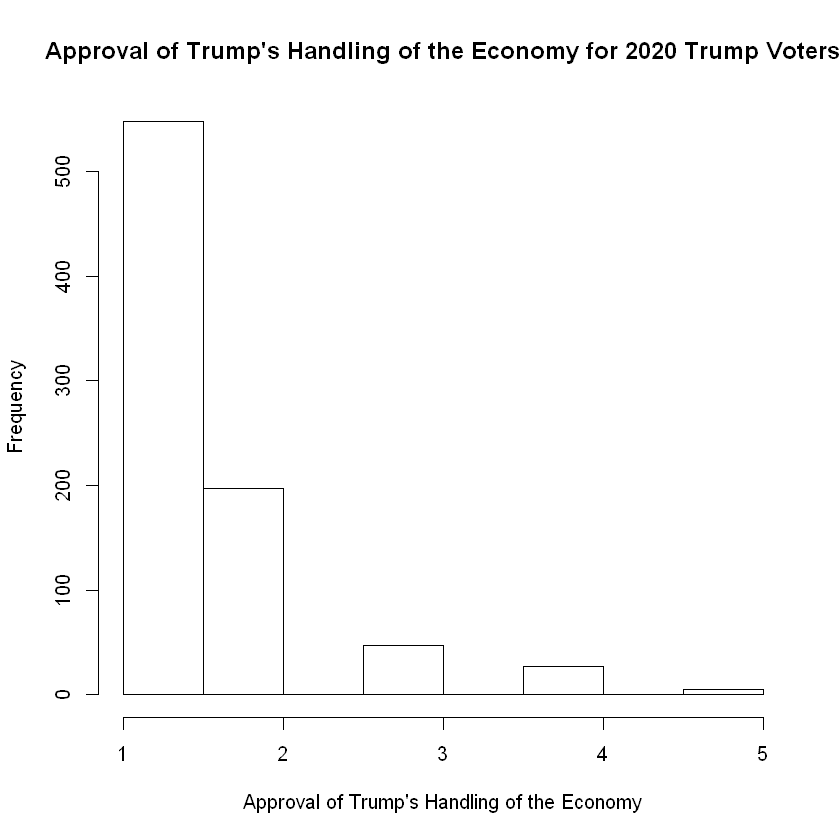

In [28]:
# Filters the dataset to if they would vote for Trump in 2020 regardless of who
# is running and if so what is their approval for Trump's handling of the economy. 

yes_trump <- subset(A, A$vote20jb == 1 & A$vote20ew == 1, select = c(econpres))

# EDA
summary(yes_trump$econpres)
sd(yes_trump$econpres)
hist(yes_trump$econpres, 
     main = "Approval of Trump's Handling of the Economy for 2020 Trump Voters",
    xlab = "Approval of Trump's Handling of the Economy")
length(yes_trump$econpres)

Based upon our data, it appears that the majority of people who plan to vote for Trump in 2020, believe Trump is handling the economy well. Our null hypothesis is that Trump voters in 2020 moderately approve that Trump is handling the economy well. Our alternative hypothesis is that Trump 2020 voters believe that Trump is handling the economy more positively than moderate approval. Therefore, we will conduct a t-test to determine how significant would it be for the mean approval of Trump's handling the economy is less than 2 indicating that Trump 2020 voters are above moderate approval of his handling of the economy. 

Our data set meets IID, because each case represents a different survey participant. The dependent variable, approval of Trump's handling of the economy, is continuous because the scale of 1-7 appears to be ordinal, but is actually a ratio since the difference between 1 to 2 is not necessarily the same as 2 to 3 or there is no proof that the difference between "approve extremely strongly" and "approve moderately strongly" is the same difference between "approve moderately strongly" and "approve slightly". Our dependent variable does not contain any outliers. Finally, our dependent variable is not normal and population standard deviation is unknown, but with n = 824, we assume it is sufficiently large enough to use a t-distribution

## T-Test

In [19]:
t.test(yes_trump$econpres, mu = 2, alternative="less", conf.level = 0.95)

# effect size
abs((mean(yes_trump$econpres)-2))/sd(yes_trump$econpres)


	One Sample t-test

data:  yes_trump$econpres
t = -18.905, df = 823, p-value < 2.2e-16
alternative hypothesis: true mean is less than 2
95 percent confidence interval:
     -Inf 1.521393
sample estimates:
mean of x 
 1.475728 


[1] 0.6586023

Our test indicates that the probability of observing a more extreme observation than the sample statistic with 95% confidence, assuming the same experiment, is extremely low. Therefore, we reject the null hypothesis for the alternate hypothesis that the true mean for 2020 Trump voters' approval of Trump's handling of the economy is less than 2, which implies that Trump voters in 2020 approve greater than moderately strongly of his handling of the economy.

Our effect size is 0.66, which tell us a slight larger than medium effect size. This means that the difference between the two means is slightly large enough and consistent enough tobe relatively important. 

# Conclusion

Our hypothesis test was to question if people who intend to vote for trump in 2020 approve of Trump's handling of the economy. Our null hypothesis was that the mean score of the 2020 Trump voters "moderately approve" at a value of 2, of Trump's handling of the economy. Our alternative hypothesis was that the true mean of 2020 Trump voters approval of Trump's handling of the economy is less than 2, indicating that they "approve extremely strongly". Since our p-value is lower than 0.05 from our 95% CI, we rejected our null hypothesis in favor of the alternative hypothesis, implying that people who intend to vote for Trump in 2020 approve his handling of the economy more than moderately strongly. Since our effect size is 0.66, our results have significant implications for democrats. If the economy crashes or does not perform well leading up to 2020, Democrats could potentially sway Trump voters in the 2020 Presidential election.